# Pemodelan AI
---
Steven Christ Pinantyo Arwidarasto

Referensi:
* https://simpletransformers.ai/docs/usage/
* https://towardsdatascience.com/how-to-train-a-bert-model-from-scratch-72cfce554fc6
* https://medium.datadriveninvestor.com/build-a-custom-q-a-model-using-bert-in-easy-steps-241547d6310f
* https://huggingface.co/course/chapter7/7?fw=pt
* https://arxiv.org/ftp/arxiv/papers/2002/2002.10107.pdf (Predicting Subjective Features of Questions of QA Websites using BERT)
* https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf (Question and Answering on SQuAD 2.0: BERT Is All You Need To Know)
* https://blog.paperspace.com/how-to-train-question-answering-machine-learning-models/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sqlalchemy as sa # Pembacaan SQL

import pandas as pd
import numpy as np
import json

# Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt

import re

In [ ]:
# Load data informasi tempat wisata
df_tourism = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PA/Tourism.csv') 

# Preprocessing

> Pengecekan nilai null dan jumlah total keseluruhan data. Terdapat 437 tempat wisata dan beberapa nilai null yang terdapat pada kolom Time_Minutes, hal ini dikarenakan tidak semua tempat wisata memiliki batas waktu yang ditetapkan kepada individu pengunjung. Oleh karena itu, akan dihapus kolom tersebut dari data

> Adapun kolom yang tidak digunakan seperti latitude, longitude, dan koordinat juga akan dihapus.

In [ ]:
df_tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    437 non-null    int64  
 1   Place_Id      437 non-null    int64  
 2   Place_Name    437 non-null    object 
 3   Description   437 non-null    object 
 4   Category      437 non-null    object 
 5   City          437 non-null    object 
 6   Price         437 non-null    float64
 7   Rating        437 non-null    float64
 8   Time_Minutes  205 non-null    float64
 9   Coordinate    437 non-null    object 
 10  Lat           437 non-null    float64
 11  Long          437 non-null    float64
dtypes: float64(5), int64(2), object(5)
memory usage: 41.1+ KB


In [ ]:
# Memasukan dataset
df_text = df_tourism.drop(['Lat','Long','Coordinate'],axis=1)
df_text.dropna(inplace=True)
df_text.head()

,Unnamed: 0,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes
0,0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,4.6,15.0
1,1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,4.6,90.0
2,2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000.0,4.6,360.0
4,4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000.0,4.5,60.0
5,5,6,Taman Impian Jaya Ancol,Taman Impian Jaya Ancol merupakan sebuah objek...,Taman Hiburan,Jakarta,25000.0,4.5,10.0


> Setelah itu, teks akan dilakukan transformasi seperti menyeragamkan huruf menjadi huruf kecil, menghapus URL, dan hanya menerima pattern string A-Z atau a-z, angka, spasi, titik, koma, dan petik.

In [ ]:
def textPreprocessing(text):
    text = text.casefold().strip()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub("[^A-Za-z0-9\s.,']","",text)
    return text

In [ ]:
# Pembersihan simbol-simbol, dan angka, serta penghapusan URL
df_text['Description'] = df_text['Description'].apply(textPreprocessing)
df_text['Place_Name'] = df_text['Place_Name'].apply(textPreprocessing)
df_text['City'] = df_text['City'].apply(textPreprocessing)
df_text['Category'] = df_text['Category'].apply(textPreprocessing)
df_text.head()

,Unnamed: 0,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes
0,0,1,monumen nasional,monumen nasional atau yang populer disingkat d...,budaya,jakarta,20000.0,4.6,15.0
1,1,2,kota tua,"kota tua di jakarta, yang juga bernama kota tu...",budaya,jakarta,0.0,4.6,90.0
2,2,3,dunia fantasi,dunia fantasi atau disebut juga dufan adalah t...,taman hiburan,jakarta,270000.0,4.6,360.0
4,4,5,atlantis water adventure,atlantis water adventure atau dikenal dengan a...,taman hiburan,jakarta,94000.0,4.5,60.0
5,5,6,taman impian jaya ancol,taman impian jaya ancol merupakan sebuah objek...,taman hiburan,jakarta,25000.0,4.5,10.0


> Data yang telah dibersihkan akan disimpan ke dalam file JSON, yang nantinya akan dilakukan modifikasi penambahan pertanyaan untuk digunakan pada klasifikasi konteks pertanyaan.

In [ ]:
json_text = df_text.to_json('/content/drive/MyDrive/Colab Notebooks/PA/CleanTourismSample.JSON',orient="index")

# Import Data Bersih

In [ ]:
data_json = pd.read_json('/content/drive/MyDrive/Colab Notebooks/PA/CleanTourismSample.JSON')

> Data bersih tersebut akan dikelompokkan ke dalam dictionary untuk dibentukan dataframenya.

In [ ]:
Description = []
Pertanyaan = []
Jawaban_Text = []
Jawaban_Akurat = []
Place_Name = []
Place_Id = []
Price = []
Average_Rating = []

for data in data_json.data:
    for i in range(len(data['Pertanyaan'])):
        Place_Id.append(data['Place_Id'])
        Place_Name.append(data['Place_Name'])
        Price.append(data['Price'])
        Average_Rating.append(data['Rating'])
        Description.append(data['Description'])
        Pertanyaan.append(data['Pertanyaan'][i]['text'])
        Jawaban_Text.append(data['Jawaban'][i]['jawaban_text'])
        Jawaban_Akurat.append(data['Jawaban'][i]['jawaban_akurat'])


data_QAS2 = pd.DataFrame({
    "Place_Id":Place_Id,
    "Place_Name":Place_Name,
    "Price":Price,
    "Average_Rating":Average_Rating,
    "Description":Description,
    "Pertanyaan":Pertanyaan,
    "Jawaban_Text":Jawaban_Text,
    "Jawaban_Akurat":Jawaban_Akurat
})

data_QAS2.to_csv('/content/drive/MyDrive/Colab Notebooks/PA/data_QAS2.csv')

# Read Json

In [ ]:
data_QAS2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PA/data_QAS2.csv")
data_QAS2.drop(['Unnamed: 0'],axis=1,inplace=True)
data_QAS2.head()

,Place_Id,Place_Name,Price,Average_Rating,Description,Pertanyaan,Jawaban_Text,Jawaban_Akurat
0,1,monumen nasional,20000.0,4.6,monumen nasional atau yang populer disingkat d...,Apa itu monumen nasional,monumen nasional atau yang populer disingkat d...,monumen nasional atau yang populer disingkat d...
1,1,monumen nasional,20000.0,4.6,monumen nasional atau yang populer disingkat d...,Dimana monumen nasional berada,tugu ini dimahkotai lidah api yang dilapisi le...,"di tengah lapangan medan merdeka, jakarta pusat."
2,1,monumen nasional,20000.0,4.6,monumen nasional atau yang populer disingkat d...,Siapa yang membuat monumen nasional,pembangunan monumen ini dimulai pada tanggal 1...,presiden soekarno
3,1,monumen nasional,20000.0,4.6,monumen nasional atau yang populer disingkat d...,Tahun berapa monumen nasional dibuat,pembangunan monumen ini dimulai pada tanggal 1...,tanggal 17 agustus 1961
4,2,kota tua,0.0,4.6,"kota tua di jakarta, yang juga bernama kota tu...",Apa itu kota tua,"kota tua di jakarta, yang juga bernama kota tu...","kota tua di jakarta, yang juga bernama kota tu..."


# Data Untuk Training Model Bert

> Pengambilan data dari SQuAD yang telah ditranslasikan ke bahasa Indonesia

In [ ]:
!wget "https://cloud.depia.wiki/squad/train-v2.0.json"
!wget "https://raw.githubusercontent.com/Wikidepia/SQuAD-id/master/data/train-SQuAD-id.json"

--2022-06-12 05:43:19--  https://cloud.depia.wiki/squad/train-v2.0.json
Resolving cloud.depia.wiki (cloud.depia.wiki)... 162.55.245.197
Connecting to cloud.depia.wiki (cloud.depia.wiki)|162.55.245.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87558609 (84M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  83.50M  26.4MB/s    in 3.6s    

2022-06-12 05:43:23 (23.5 MB/s) - ‘train-v2.0.json’ saved [87558609/87558609]

--2022-06-12 05:43:23--  https://raw.githubusercontent.com/Wikidepia/SQuAD-id/master/data/train-SQuAD-id.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37852227 (36M) [text/plain]
Saving to: ‘train-SQuAD-id.json’

train-SQuAD-id.json 100%[===================>]  3

In [ ]:
""" 
  Refensi: 
  https://github.com/Wikidepia/indonesian_datasets/tree/master/question-answering/squad
"""
"""
dataset = pd.read_json("https://cloud.depia.wiki/squad/train-v2.0.json",
             orient='records', dtype='dict')
"""
dataset = pd.read_json("https://raw.githubusercontent.com/Wikidepia/SQuAD-id/master/data/train-SQuAD-id.json",
             orient='records', dtype='dict')
dataset.head()

,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...


> Pembacaan data SQuAD yang berbentuk json

In [ ]:
"""
  Data Training model BERT
"""
import json


with open("/content/train-SQuAD-id.json", 'r') as f:
    train_data = json.load(f)

train_data = [item for topic in train_data['data'] for item in topic['paragraphs']]

> Import data tourism untuk kebutuhan klasifikasi konteks

In [ ]:
textContext = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PA/Tourism.csv")
textContext.head()

,Unnamed: 0,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000.0,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000.0,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000.0,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134


In [ ]:
textContext.shape

(437, 12)

# BERT-QAS

> Untuk pelatihan QAS, akan digunakan fine-tuned indo-bert-uncased dengan menggunakan simpletransformers
---
Referensi: https://simpletransformers.ai/docs/qa-model/

In [ ]:
# Instalasi lib
!pip install -q simpletransformers

     |████████████████████████████████| 249 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 70.0 MB/s 
     |████████████████████████████████| 9.1 MB 22.6 MB/s 
     |████████████████████████████████| 1.8 MB 49.0 MB/s 
     |████████████████████████████████| 6.6 MB 46.9 MB/s 
     |████████████████████████████████| 4.2 MB 58.6 MB/s 
     |████████████████████████████████| 346 kB 74.2 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 56.3 MB/s 
     |████████████████████████████████| 145 kB 77.3 MB/s 
     |████████████████████████████████| 181 kB 68.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 86 kB 7.2 MB/s 
     |████████████████████████████████| 140 kB 69.0 MB/s 
     |████████████████████████████████| 1.1 MB 63.0 MB/s 
     |████████████████████████████████| 212 kB 68.4 MB/s 
     |█████████████████

In [ ]:
from simpletransformers.question_answering import QuestionAnsweringModel, QuestionAnsweringArgs

## Konfigurasi Model

In [ ]:
"""
  Inisialisasi nama model dan tipe modelnya
"""
model_type="bert"
# model_name= "indolem/indobert-base-uncased"
model_name = "/content/drive/MyDrive/Colab Notebooks/PA/best_save_model2"
# model_name = "/content/drive/MyDrive/Colab Notebooks/PA/saved_model2/checkpoint-51813-epoch-4"

In [ ]:
"""
  Konfigurasi model untuk QASnya dengan menggunakan adam_epsilon, dan pengaturan
  direktori penyimpanan checkpoint
"""
model_args = QuestionAnsweringArgs()
model_args.train_batch_size = 16
model_args.n_best_size=3
model_args.num_train_epochs=10
model_args.evaluate_during_training = True
model_args.adam_epsilon=1e-8
# model_args.lazy_loading = True
model_args.optimizer='AdamW'
model_args.best_model_dir="/content/drive/MyDrive/Colab Notebooks/PA/best_save_model2"
model_args.cache_dir="/content/drive/MyDrive/Colab Notebooks/PA/caches"
model_args.overwrite_output_dir="/content/drive/MyDrive/Colab Notebooks/PA/output"
model_args.sliding_window=True

model = QuestionAnsweringModel(
    model_type, model_name, args=model_args, use_cuda=False
)

## Training Model

In [ ]:
# Pembagian data untuk training dan testing
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(train_data,test_size=0.2, random_state=42)

In [ ]:
model.train_model(X_train,overwrite_output_dir="/content/drive/MyDrive/Colab Notebooks/PA/saved_model3",
                  show_running_loss=True,
                  eval_data=X_test)

add example index and unique id: 100%|██████████| 91792/91792 [00:00<00:00, 834077.61it/s]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/5757 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


convert squad examples to features:   0%|          | 0/23033 [00:00<?, ?it/s]

convert squad examples to features:   0%|          | 1/23033 [01:14<478:19:57, 74.77s/it]

convert squad examples to features: 100%|██████████| 23033/23033 [02:27<00:00, 155.89it/s]


add example index and unique id: 100%|██████████| 23033/23033 [00:00<00:00, 805598.77it/s]


Running Evaluation:   0%|          | 0/2889 [00:00<?, ?it/s]

TypeError: ignored

## Model Testing Menggunakan Simpletransformers

> Percobaan pengujian QAS dengan simpletransformers

In [ ]:
text = " ".join(textContext['Description'])

In [ ]:
predictions, raw_outputs = model.predict(
    [
        {
            "context": text,
            "qas": [
                {
                    "question": data_QAS2['Pertanyaan'][1],
                    "id": "0",
                }
            ],
        }
    ]
)

predictions, raw_outputs

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 4733.98it/s]


Running Prediction:   0%|          | 0/17 [00:00<?, ?it/s]

([{'answer': ['ibukota Jawa Tengah',
    'di ibukota Jawa Tengah',
    'ibukota Jawa Tengah ini'],
   'id': '0'}],
 [{'id': '0',
   'probability': [0.685648810701097,
    0.26075171834989036,
    0.05359937641108391]}])

> Berdasarkan percobaan diatas, model tidak dapat mendapatkan jawaban dari konteks yang disatukan, oleh karena itu, dikarenakan keterbatasan data tourism dan pertanyaan, saya memilih untuk melakukan klasifikasi pertanyaan ke dalam konteks tempat wisatanya

## Model Lib Transformers

In [ ]:
pip install -q transformers

In [ ]:
from transformers import BertTokenizer, BertForQuestionAnswering
import torch

# Klasifikasi Topik Pertanyaan

> Untuk melakukan training klasifikasi pertanyaan, kami menggunakan data kumpulan pertanyaan yang kami buat berdasarkan tempat wisatanya masing-masing. Berikut data yang ada:

## Data Preprocessing

In [ ]:
data_QAS2.columns

Index(['Place_Id', 'Place_Name', 'Price', 'Average_Rating', 'Description',
       'Pertanyaan', 'Jawaban_Text', 'Jawaban_Akurat'],
      dtype='object')

In [ ]:
# Seleksi Fitur Place_Id, Place_Name, dan Pertanyaan
data_klasifikasi = data_QAS2[['Pertanyaan','Place_Name','Place_Id']]
data_klasifikasi.dropna()
data_klasifikasi.shape

(143, 3)

In [ ]:
# Standarisasi huruf kecil
data_klasifikasi['Place_Name'] = data_klasifikasi['Place_Name'].apply(lambda x:x.lower().strip())
data_klasifikasi['Pertanyaan'] = data_klasifikasi['Pertanyaan'].apply(lambda x:x.lower().strip())
data_klasifikasi.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Pertanyaan,Place_Name,Place_Id
0,apa itu monumen nasional,monumen nasional,1
1,dimana monumen nasional berada,monumen nasional,1
2,siapa yang membuat monumen nasional,monumen nasional,1
3,tahun berapa monumen nasional dibuat,monumen nasional,1
4,apa itu kota tua,kota tua,2


In [ ]:
data_klasifikasi.groupby('Place_Id')['Pertanyaan'].count()

Place_Id
1     4
2     3
3     3
4     2
5     2
     ..
78    1
79    3
80    1
81    1
82    2
Name: Pertanyaan, Length: 80, dtype: int64

In [ ]:
X = data_klasifikasi['Pertanyaan']
y = data_klasifikasi['Place_Id']

In [ ]:
from sklearn.model_selection import train_test_split

data_klasifikasi_train, data_klasifikasi_test = train_test_split(data_klasifikasi,test_size=0.2, random_state=20)
data_klasifikasi_test, data_klasifikasi_val = train_test_split(data_klasifikasi_test,test_size=0.2, random_state=20)

print(f'X_train {data_klasifikasi_train.shape}')
print(f'X_test {data_klasifikasi_test.shape}')
print(f'X_val {data_klasifikasi_val.shape}')

X_train (114, 3)
X_test (23, 3)
X_val (6, 3)


# LSTM Klasifikasi

In [ ]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 237 kB 5.3 MB/s 


In [ ]:
# Klasifikasi Place_Id
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle

## Tokenisasi

In [ ]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(data_klasifikasi['Pertanyaan'].values)
word_index = tokenizer.word_index


# Penyimpanan tokenizer
with open('/content/drive/MyDrive/Colab Notebooks/PA/tokenizerTextClassification.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X = tokenizer.texts_to_sequences(data_klasifikasi['Pertanyaan'].values)
print(X)
X = pad_sequences(X,maxlen=20) # pemberian maxlen = 20 berdasarkan token terpanjang
print(X.shape)

[[2, 13, 18, 14], [1, 18, 14, 25], [35, 4, 52, 18, 14], [144, 36, 18, 14, 53], [2, 13, 22, 54], [1, 22, 54, 25], [35, 4, 52, 18, 14], [2, 13, 145, 146, 55, 37], [1, 3, 37], [9, 37, 38], [2, 13, 10, 56], [1, 3, 10, 56], [2, 13, 57, 58, 59], [1, 3, 57, 58, 59], [2, 13, 10, 60, 61, 26], [1, 11, 10, 60, 61, 26], [2, 13, 23, 27, 28], [1, 3, 23, 27, 28], [9, 23, 27, 28, 53], [2, 4, 147, 7, 23, 27, 28], [2, 13, 62, 63], [1, 3, 62, 63], [2, 13, 64, 65], [1, 3, 64, 65], [1, 3, 16, 66], [1, 3, 16, 66], [1, 3, 16, 67], [1, 3, 16, 67], [1, 3, 10, 68], [2, 69, 70, 29, 10, 68], [2, 13, 5, 24, 71, 39, 72], [1, 3, 5, 24, 71, 39, 72], [1, 3, 16, 73], [2, 12, 4, 74, 7, 16, 73], [2, 13, 17, 24], [9, 17, 24, 19], [9, 148, 149, 75, 17, 24], [9, 150, 17, 24], [9, 40, 22, 41, 151], [35, 4, 152, 40, 22, 41], [1, 3, 40, 22, 41], [1, 3, 5, 42], [2, 69, 153, 5, 42], [9, 5, 42, 20], [1, 3, 5, 76, 15], [9, 5, 76, 15, 20, 75, 154], [2, 13, 155], [1, 3, 5, 10, 77], [2, 12, 4, 78, 43, 5, 10, 77], [1, 3, 11, 5, 156], 

> Transformasi data target yang berisi id tempat wisata menjadi data kategorikal

In [ ]:
Y = pd.get_dummies(data_klasifikasi['Place_Id']).values
Y.shape

(143, 80)

In [ ]:
Y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

> Pembagian data training dan testing

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=0)

## Konfigurasi Model dan Training

In [ ]:
%%time
# Inisialisasi model menggunakan LSTM

input = tf.keras.layers.Input(shape=X.shape[1])
embed = tf.keras.layers.Embedding(10000,10000, input_length = X.shape[1])(input)
lstm = tf.keras.layers.LSTM(100) (embed)
layer_dense = tf.keras.layers.Dense(128, activation="elu", kernel_regularizer="l2")(lstm)
layer_dense = tf.keras.layers.BatchNormalization()(layer_dense)
layer_dense = tf.keras.layers.Dense(128, activation="elu", kernel_regularizer="l2")(layer_dense)
layer_dense = tf.keras.layers.BatchNormalization()(layer_dense)
layer_dense = tf.keras.layers.Dense(128, activation="elu", kernel_regularizer="l2")(layer_dense)
layer_dense = tf.keras.layers.BatchNormalization()(layer_dense)
layer_dense = tf.keras.layers.Dense(128, activation="elu", kernel_regularizer="l2")(layer_dense)

layer_dense = tf.keras.layers.Dense(128, activation="elu", kernel_regularizer="l2")(layer_dense)
output = tf.keras.layers.Dense(Y.shape[1], activation='softmax')(layer_dense)


model = tf.keras.Model(inputs=input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")])

epochs = 25
batch_size = 16
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/25
7/7 [==============================] - 4s 165ms/step - loss: 10.4492 - accuracy: 0.0882 - val_loss: 10.5167 - val_accuracy: 0.0833
Epoch 2/25
7/7 [==============================] - 0s 65ms/step - loss: 8.4586 - accuracy: 0.6569 - val_loss: 10.3374 - val_accuracy: 0.1667
Epoch 3/25
7/7 [==============================] - 0s 66ms/step - loss: 7.5474 - accuracy: 0.8137 - val_loss: 10.1283 - val_accuracy: 0.2500
Epoch 4/25
7/7 [==============================] - 0s 68ms/step - loss: 6.9580 - accuracy: 0.9216 - val_loss: 9.9261 - val_accuracy: 0.2500
Epoch 5/25
7/7 [==============================] - 0s 68ms/step - loss: 6.5167 - accuracy: 0.9510 - val_loss: 9.7388 - val_accuracy: 0.2500
Epoch 6/25
7/7 [==============================] - 0s 68ms/step - loss: 6.2114 - accuracy: 0.9804 - val_loss: 9.5185 - val_accuracy: 0.4167
Epoch 7/25
7/7 [==============================] - 0s 68ms/step - loss: 6.0103 - accuracy: 0.9804 - val_loss: 9.2997 - val_accuracy: 0.4167
Epoch 8/25
7/7 [======

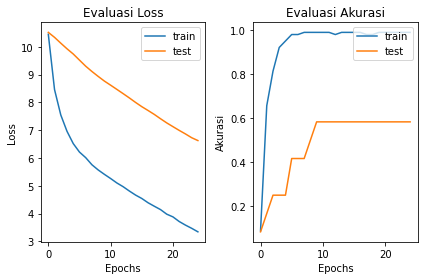

In [ ]:
# Evaluasi LSTM 
fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='test')
ax[0].title.set_text('Evaluasi Loss')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(loc="upper right")



ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='test')
ax[1].title.set_text('Evaluasi Akurasi')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Akurasi")
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show();

> Adapun akurasi yang di dapatkan berkisar antara 50% sampai 58.3% untuk beberapa kali percobaan

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/PA/saved_model_clasif/ClassificationLSTM.h5")

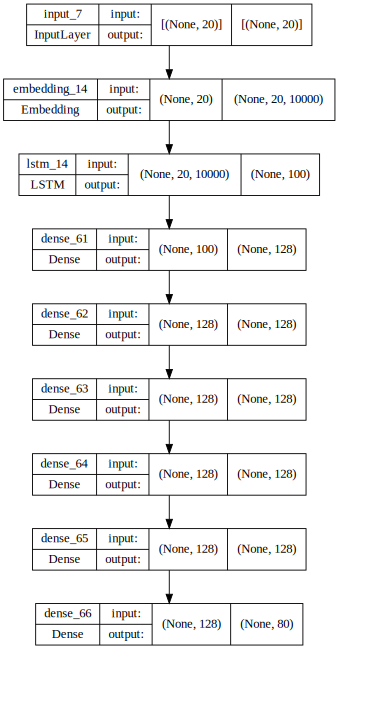

In [ ]:
import tensorflow as tf
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/PA/saved_model_clasif/ClassificationLSTM.h5')

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

## Model Testing

In [ ]:
textContext.head()

,Unnamed: 0,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000.0,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000.0,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000.0,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134


In [ ]:
import tensorflow as tf
# Import Model Text Classification
LSTMKlasifikasi = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/PA/saved_model_clasif/ClassificationLSTM.h5")

# Pengambilan token
with open('/content/drive/MyDrive/Colab Notebooks/PA/tokenizerTextClassification.pickle', 'rb') as handle:
    tokenizerTC = pickle.load(handle)

# Import Model BERT untuk QAS
tokenizerBERT = BertTokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/PA/best_save_model2")
model = BertForQuestionAnswering.from_pretrained("/content/drive/MyDrive/Colab Notebooks/PA/best_save_model2")

In [ ]:
"""
  Sebelum digunakan, konteks (deskripsi tempat wisata) 
  akan dibersihkan dari emoji, dan pattern url. Selain itu
  akan dilakukan casefolding untuk mentransformasikan huruf menjadi
  huruf kecil.
"""
import re
def textPreprocessing(text):
    text = text.casefold().strip()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub("[^A-Za-z0-9\s.,']","",text)
    return text

In [ ]:
"""
  Modifikasi Data:
  
  * Penambahan harga tiket, dan rata-rata rating tempat wisata ke dalam description
"""
for i in range(len(textContext)):
  textContext['Description'][i] += " Tempat wisata ini memiliki Harga tiket sebesar "+\
  str(int(textContext['Price'][i]))+" dan memiliki rating "+str(textContext['Rating'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
textContext['Description'] = textContext['Description'].apply(textPreprocessing)

In [ ]:
print(textContext['Description'])

0      monumen nasional atau yang populer disingkat d...
1      kota tua di jakarta, yang juga bernama kota tu...
2      dunia fantasi atau disebut juga dufan adalah t...
3      taman mini indonesia indah merupakan suatu kaw...
4      atlantis water adventure atau dikenal dengan a...
                             ...                        
432    museum negeri mpu tantular adalah sebuah museu...
433    taman bungkul adalah taman wisata kota yang te...
434    air mancur menari atau dancing fountain juga a...
435    taman flora adalah salah satu taman kota di su...
436    gereja katolik kelahiran santa perawan maria m...
Name: Description, Length: 437, dtype: object


In [ ]:
# Fungsi QAS yang menghasilkan jawaban berdasarkan konteks
def qas(tokenizer,model,pertanyaan,text):
  hasil = ""
  
  inputIds = tokenizer.encode(pertanyaan, text)
  tokens = tokenizer.convert_ids_to_tokens(inputIds)
  nilaiSEP = inputIds.index(tokenizer.sep_token_id)
  segmen=[0]*(nilaiSEP+1) + [1]*(len(inputIds)-(nilaiSEP+1))
  
  outputLogits = model(torch.tensor([inputIds]), token_type_ids=torch.tensor([segmen]))
  
  indexAwalJawaban = torch.argmax(outputLogits.start_logits)
  indexAkhirJawaban = torch.argmax(outputLogits.end_logits)
  
  if(indexAkhirJawaban >= indexAwalJawaban):
    hasil = tokens[indexAwalJawaban]
    for i in range(indexAwalJawaban+1, indexAkhirJawaban+1):
      if(tokens[i][0:2] == '##'):
        hasil += tokens[i][2:]
      else:
        hasil += ' ' + tokens[i]
      
    if hasil.startswith('[CLS]'):
      hasil ="Mohon maaf, kami tidak dapat menemukan jawaban."
      
    return hasil.capitalize()

# Fungsi klasifikasi konteks
def klasifikasiKonteks(model, pertanyaan):
  X = pad_sequences(tokenizer.texts_to_sequences([pertanyaan.casefold()]),maxlen=20)

  prediksi = [i+1 for i in np.argmax(model.predict(X), axis = 1)]
  return prediksi

# Pemanggilan QAS
def jawabanPertanyaan(tokenizer,model,pertanyaan, label):
  context = textContext[textContext.Place_Id == label]['Description'].values[0]
  return qas(tokenizer,model,pertanyaan,context)

In [ ]:
pertanyaan = "Apa itu monumen nasional?"

label = klasifikasiKonteks(LSTMKlasifikasi, pertanyaan)
jawabanPertanyaan(tokenizerBERT,model,pertanyaan,label[0])

'Monumen peringatan setinggi 132 meter 433 kaki'

In [ ]:
# Pengujian klasifikasi
X = pad_sequences(tokenizer.texts_to_sequences(["Siapa yang membangun monumen nasional?".casefold()]),maxlen=20)

prediksi = [i+1 for i in np.argmax(LSTMKlasifikasi.predict(X), axis = 1)]
prediksi

[1]

# Percobaan Optimisasi Model Konversi TFLITE
---
Referensi:
* https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/examples/experimental_new_converter/Keras_LSTM_fusion_Codelab.ipynb#scrollTo=0-b0IKK2FGuO
* https://www.tensorflow.org/lite/performance/post_training_quant 

> Kami mengetahui bahwa, model untuk klasifikasi konteks menghasilkan file dengan besar 1GB, oleh karena itu, kami ingin melakukan optimisasi terhadap performa serta besar file yang dibutuhkan oleh model dengan menggunakan Tensorflow Lite

In [ ]:
import tensorflow as tf
import os
import pathlib

> Model LSTM yang telah dilakukan training akan diimport

In [ ]:
LSTMKlasifikasi = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/PA/saved_model_clasif/ClassificationLSTM.h5")

> Pengecekan input shape dan konversi model ke tflite

In [ ]:
LSTMKlasifikasi.inputs[0]

<KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'input_7')>

In [ ]:
run_model = tf.function(lambda x: LSTMKlasifikasi(x))

BATCH_SIZE = 1
STEPS = 20
# INPUT_SIZE = X_test.shape[1]
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS], LSTMKlasifikasi.inputs[0].dtype))

MODEL_DIR = "/content/drive/MyDrive/Colab Notebooks/PA/keras_lstm"
LSTMKlasifikasi.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PA/keras_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PA/keras_lstm/assets
2022-06-06 07:01:18.042271: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-06-06 07:01:18.042333: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


In [ ]:
X_test[0:1, :]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          8,   4,  75,  15,  20,  74, 154]], dtype=int32)

In [ ]:
np.array([X_test[0, :]]).astype('float32')

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   8.,   4.,  75.,  15.,  20.,  74., 154.]],
      dtype=float32)

In [ ]:
# Prediksi hasil klasifikasi menggunakan dataset X_test
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

hasil = []
for i in range(X_test.shape[0]):
  interpreter.set_tensor(input_details[0]["index"], np.array([X_test[i, :]]).astype('float32'))
  interpreter.invoke()
  hasil.append(np.argmax(interpreter.get_tensor(output_details[0]["index"])))
  interpreter.reset_all_variables()

In [ ]:
# Konversi nilai object prob menjadi kelas klasifikasinya
hasil_model_asli = [np.argmax(i) for i in LSTMKlasifikasi.predict(X_test)]

In [ ]:
# Membandingkan dengan prediksi model hasil untuk mengetahui berapa jumlah loss setelah dilakukan compression
salah = 0
for i in range(len(hasil_model_asli)): 
  if hasil[i] != hasil_model_asli[i]:
    salah += 1

print(((len(hasil_model_asli)-salah)/len(hasil_model_asli))*100)

100.0


# Penyimpanan dalam file TFLITE

In [ ]:
import pathlib

DIR = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/PA/")
tflite_file = DIR/"LSTMKlasifikasiKonteks.tflite"
tflite_file.write_bytes(tflite_model)

416524532

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = DIR/"LSTMKlasifikasiKonteksQuants.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

2022-06-06 07:04:32.408608: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-06-06 07:04:32.409376: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


104139840

# Upload TFLITE

In [ ]:
# DIR
DIR_MODEL = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/PA/")

# Non Quant
interpreter = tf.lite.Interpreter(model_path=str(DIR_MODEL/"LSTMKlasifikasiKonteks.tflite"))
interpreter.allocate_tensors()

# Quant
interpreter_quant = tf.lite.Interpreter(model_path=str(DIR_MODEL/"LSTMKlasifikasiKonteksQuants.tflite"))
interpreter_quant.allocate_tensors()

In [ ]:
interpreter.get_input_details()

[{'name': 'serving_default_x:0',
  'index': 0,
  'shape': array([ 1, 20], dtype=int32),
  'shape_signature': array([ 1, 20], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
generateDataTensor(X_test[0,:])

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   8.,   4.,  75.,  15.,  20.,  74., 154.]],
      dtype=float32)

In [ ]:
X = pad_sequences(tokenizer.texts_to_sequences(["Siapa yang membangun monumen nasional?".casefold()]),maxlen=20)

In [ ]:
X.astype('float32')

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  52.,   5., 152.,  22.,  14.]],
      dtype=float32)

In [ ]:
def generateDataTensor(data, axis=0):
    return np.expand_dims(data, axis=axis).astype(np.float32)

def getRecommendation(interpreter):
  input_index = interpreter.get_input_details()[0]['index']
  output_index = interpreter.get_output_details()[0]['index']

  print(input_index," ",output_index)
  prediksi = []
  for i in range(X_test.shape[0]):
      interpreter.set_tensor(input_index, generateDataTensor(X_test[i,:]))
      interpreter.invoke()
      prediksi.append(np.argmax(interpreter.get_tensor(output_index)))
  
  salah = 0
  for i in range(len(hasil_model_asli)): 
    if prediksi[i] != hasil_model_asli[i]:
      salah += 1

  print(((len(hasil_model_asli)-salah)/len(hasil_model_asli))*100)

In [ ]:
print("Model Non-Quantiz")
getRecommendation(interpreter)

print("\nModel Quantiz")
getRecommendation(interpreter_quant)

Model Non-Quantiz
0   41
100.0

Model Quantiz
0   41
93.10344827586206


> Ditemukan bila menggunakan TFLITE tanpa optimize akan menghasilkan besar berkas 397,2 MB, sedangkan model Quantized memiliki besar file 99,8 MB

> Selain itu, ditemukan ada penurunan sebesar 6,9% antara model quantiz dibandingkan dengan hasil model LSTM tanpa optimisasi dan model tanpa metode quantize